In [1]:
from __future__ import print_function
from collections import OrderedDict

import matplotlib.pyplot as plt
import numpy as np

from nn_transfer import transfer, util

%matplotlib inline

Using Theano backend.


## Step 1
Simply define your PyTorch model like usual, and create an instance of it.

In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.max_pool2d(out, 2)
        out = F.relu(self.conv2(out))
        out = F.max_pool2d(out, 2)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
pytorch_network = LeNet()

## Step 2
Determine the names of the layers.

For the above model example it is very straightforward, but if you use param groups it may be a little more involved. To determine the names of the layers the next commands are useful:

In [3]:
# The most useful, just print the network
print(pytorch_network)

# Also useful: will only print those layers with params
state_dict = pytorch_network.state_dict()
print(util.state_dict_layer_names(state_dict))

LeNet (
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear (400 -> 120)
  (fc2): Linear (120 -> 84)
  (fc3): Linear (84 -> 10)
)
['conv1', 'conv2', 'fc1', 'fc2', 'fc3']


## Step 3
Define an equivalent Keras network. Use the built-in `name` keyword argument for each layer with params.

In [4]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
K.set_image_data_format('channels_first')


def lenet_keras():

    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5),
                     activation='relu',
                     input_shape=(1,32,32),
                     name='conv1'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(16, (5, 5), activation='relu', name='conv2'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation='relu', name='fc1'))
    model.add(Dense(84, activation='relu', name='fc2'))
    model.add(Dense(10, activation=None, name='fc3'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta())
    
    return model
    
keras_network = lenet_keras()

## Step 4
Now simply convert!

In [5]:
transfer.keras_to_pytorch(keras_network, pytorch_network)

Layer names in target ['conv1', 'conv2', 'fc1', 'fc2', 'fc3']
Layer names in Keras HDF5 ['conv1', 'conv2', 'fc1', 'fc2', 'fc3', 'flatten_1', 'max_pooling2d_1', 'max_pooling2d_2']


## Done!

Now let's check whether it was succesful. If it was, both networks should have the same output.

In [6]:
# Create dummy data
data = torch.rand(6,1,32,32)
data_keras = data.numpy()
data_pytorch = Variable(data, requires_grad=False)

# Do a forward pass in both frameworks
keras_pred = keras_network.predict(data_keras)
pytorch_pred = pytorch_network(data_pytorch).data.numpy()

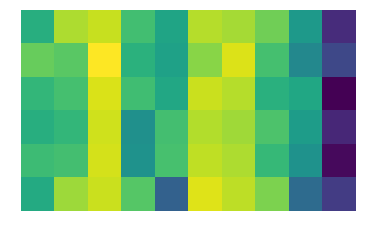

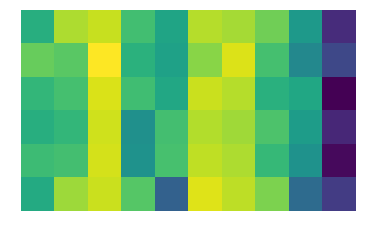

In [7]:
assert keras_pred.shape == pytorch_pred.shape

plt.axis('Off')
plt.imshow(keras_pred)
plt.show()
plt.axis('Off')
plt.imshow(pytorch_pred)
plt.show()

They are the same, it works :)